In [1]:
import numpy as np
import pandas as pd
from torch import nn
from phmd import datasets
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, RobustScaler
from scipy.stats import kurtosis
from scipy.fft import fft
from scipy.fft import fft, fftfreq
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
from tqdm import tqdm

/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [2]:
def early_prediction_score(y_true, y_pred, alpha=0.5):
    errors = y_pred - y_true
    # Heavier penalty for late predictions
    weights = np.where(errors < 0, alpha, 1)
    return np.mean(weights * errors**2)

In [3]:
TRAIN_BEARINGS = {
    1: [
        '1_1',
        # '1_2',
    ],
    2: [
        '2_1',
        '2_2',
    ],
    3: [
        '3_1',
        '3_2',
    ]
}

TEST_BEARINGS = {
    1: [
        '1_3',
        '1_4',
        '1_5',
        '1_6',
        '1_7',
    ],
    2: [
        '2_3',
        '2_4',
        '2_5',
        '2_6',
        '2_7',
    ],
    3: [
        '3_3',
    ]
}

In [4]:
dataset = datasets.Dataset('PRONOSTIA')
tasks = dataset['rul']
df = tasks.load()

Remember to cite the original publisher dataset:
	@inproceedings{nectoux2012pronostia,    
	    title={PRONOSTIA: An experimental platform for bearings accelerated degradation tests.},    
	    author={Nectoux, Patrick and Gouriveau, Rafael and Medjaher, Kamal and Ramasso, Emmanuel and Chebel-Morello, Brigitte and Zerhouni, Noureddine and Varnier, Christophe},    
	    booktitle={IEEE International Conference on Prognostics and Health Management, PHM'12.},    
	    pages={1--8},    
	    year={2012},    
	    organization={IEEE Catalog Number: CPF12PHM-CDR}    
	}
You can download the dataset manually from:  https://www.nasa.gov/intelligent-systems-division/discovery-and-systems-health/pcoe/pcoe-data-set-repository/

** If you find this tool useful, please cite our SoftwareX paper: 
	Solís-Martín, David, Juan Galán-Páez, and Joaquín Borrego-Díaz. "PHMD: An easy data access tool for prognosis and health management datasets." SoftwareX 29 (2025): 102039.



Reading Bearing3_3: 100%|██████████| 13959/13959 [00:35<00:00, 390.76it/s]
INFO:root:Read in 57.81956434249878 seconds


In [5]:
# train
df[0]['unit'].unique()

array(['1_1', '1_2', '2_1', '2_2', '3_1', '3_2'], dtype=object)

In [6]:
df[0].head(5)

,rul,V_acc,H_acc,unit
0,28029,-0.146,0.552,1_1
1,28029,-0.480,0.501,1_1
2,28029,0.435,0.138,1_1
3,28029,0.240,-0.423,1_1
4,28029,0.020,-0.802,1_1


In [7]:
# test
df[1]['unit'].unique()

array(['1_3', '1_4', '1_5', '1_6', '1_7', '2_3', '2_4', '2_5', '2_6',
       '2_7', '3_3'], dtype=object)

In [8]:
df[0][df[0]['unit'].isin(TRAIN_BEARINGS[1])]['unit']

0          1_1
1          1_1
2          1_1
3          1_1
4          1_1
          ... 
7175675    1_1
7175676    1_1
7175677    1_1
7175678    1_1
7175679    1_1
Name: unit, Length: 7175680, dtype: object

In [9]:
df[0][df[0]['unit'].isin(TRAIN_BEARINGS[1])]

,rul,V_acc,H_acc,unit
0,28029,-0.146,0.552,1_1
1,28029,-0.480,0.501,1_1
2,28029,0.435,0.138,1_1
3,28029,0.240,-0.423,1_1
4,28029,0.020,-0.802,1_1
...,...,...,...,...
7175675,0,2.129,-3.353,1_1
7175676,0,-2.299,-2.868,1_1
7175677,0,-1.844,-5.507,1_1
7175678,0,2.146,-3.578,1_1


In [10]:
df[1][df[1]['unit'].isin(TEST_BEARINGS[1])]

,rul,V_acc,H_acc,unit
0,23749,0.044,0.092,1_3
1,23749,0.432,-0.025,1_3
2,23749,0.008,-0.104,1_3
3,23749,-0.264,0.056,1_3
4,23749,-0.195,0.074,1_3
...,...,...,...,...
3845115,7570,-0.013,0.481,1_7
3845116,7570,-0.272,0.191,1_7
3845117,7570,0.466,0.250,1_7
3845118,7570,-0.582,0.001,1_7


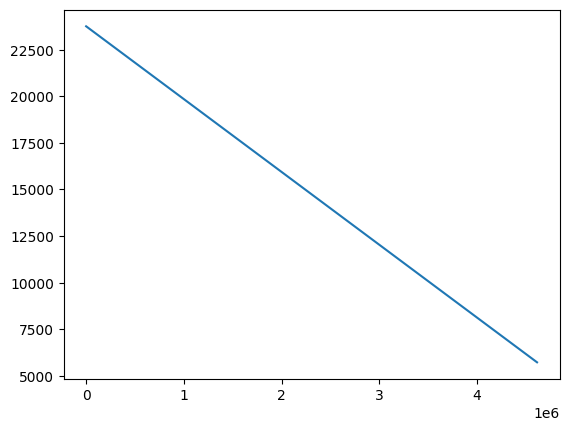

In [11]:
plt.plot(df[1][df[1]['unit'] == '1_3']['rul'])

In [12]:
# sns.kdeplot(df[0][df[0]['unit'] == '1_1']['H_acc'], label='Train')
# sns.kdeplot(test_features['h_RMS'], label='Test')
# plt.legend(); plt.show()

In [308]:
class BearingDataset(torch.utils.data.Dataset):
    def __init__(self, df, window_size=2560, step=2560 // 2):
        self.windows = []
        self.ruls = []
        
        # Create sequences
        for unit, group in df.groupby('unit'):
            h_acc =  group['H_acc'].transform(
                lambda x: (x - x.mean()) / (x.std() + 1e-8)
            )
            v_acc =  group['V_acc'].transform(
                lambda x: (x - x.mean()) / (x.std() + 1e-8)
            )

            rul = group['rul'].transform(lambda x: x / x.max())

            for i in range(0, len(group) - window_size, step):

                self.windows.append(np.stack([
                    h_acc[i:i+window_size], 
                    v_acc[i:i+window_size]
                ], axis=1))
                self.ruls.append(rul.values[i+window_size-1])

    def __len__(self):
        return len(self.windows)
    
    def __getitem__(self, idx):
        return torch.FloatTensor(self.windows[idx]), torch.FloatTensor([self.ruls[idx]])
    
    def create_overlapping_windows(signal, window_size=2560, overlap=0.75):
        step = int(window_size * (1 - overlap))
        return np.lib.stride_tricks.sliding_window_view(
            signal, window_shape=window_size, axis=0
        )[::step]
    
train_dataset = BearingDataset(
    # [b for state in TRAIN_BEARINGS for b in TRAIN_BEARINGS[state]]
    df=df[0][df[0]['unit'].isin(['1_1'])],
)

test_dataset = BearingDataset(
    df=df[1][df[1]['unit'] == '1_3'],
)

val_dataset = BearingDataset(
    df=df[0][df[0]['unit'] == '1_2'],
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

In [309]:
len(train_dataset)

5604

In [310]:
class BearingCNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        # Feature extractor
        self.features = torch.nn.Sequential(
            # Layer 1: Wide receptive field
            torch.nn.Conv1d(2, 64, kernel_size=51, padding=25),  # (B, 2, 2560) -> (B, 64, 2560)
            torch.nn.BatchNorm1d(64),
            torch.nn.LeakyReLU(0.1),
            torch.nn.MaxPool1d(4, stride=2),  # -> (B, 64, 1278)
            
            # Layer 2: Mid-range features
            torch.nn.Conv1d(64, 128, kernel_size=25, padding=12),  # -> (B, 128, 1278)
            torch.nn.BatchNorm1d(128),
            torch.nn.LeakyReLU(0.1),
            torch.nn.MaxPool1d(4, stride=2),  # -> (B, 128, 637)
            
            # Layer 3: Local features
            torch.nn.Conv1d(128, 256, kernel_size=10, padding=5),  # -> (B, 256, 637)
            torch.nn.BatchNorm1d(256),
            torch.nn.LeakyReLU(0.1),
            torch.nn.AdaptiveAvgPool1d(1)  # -> (B, 256, 1)
        )
        
        # Regressor (fixed input dim)
        self.regressor = torch.nn.Sequential(
            torch.nn.Linear(256, 128),
            torch.nn.LayerNorm(128),  # Better for regression
            torch.nn.LeakyReLU(0.1),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(128, 1),
            # torch.nn.Sigmoid(),
            # Removed Sigmoid() for regression
        )

        # self.fc = torch.nn.Linear(128, 1)

        # with torch.no_grad():
        #     self.fc.weight.data = -torch.abs(self.fc.weight.data)
        #     self.fc.bias.data.fill_(1.0)  # Start predictions near 1.0
    
    def forward(self, x):
        # Input: (B, 2560, 2)
        x = x.permute(0, 2, 1)  # -> (B, 2, 2560)
        x = self.features(x)     # -> (B, 256, 1)
        x = x.squeeze(-1)        # -> (B, 256)
        x = self.regressor(x)  # -> (B,)
        return x

model = BearingCNN()

print(model)

BearingCNN(
  (features): Sequential(
    (0): Conv1d(2, 64, kernel_size=(51,), stride=(1,), padding=(25,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): MaxPool1d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(64, 128, kernel_size=(25,), stride=(1,), padding=(12,))
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.1)
    (7): MaxPool1d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv1d(128, 256, kernel_size=(10,), stride=(1,), padding=(5,))
    (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.1)
    (11): AdaptiveAvgPool1d(output_size=1)
  )
  (regressor): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): LayerNorm((128,), eps=1e-05, elementwise_affine=

In [311]:
class LogCoshLoss(nn.Module):
    def forward(self, y_pred, y_true):
        return torch.mean(torch.log(torch.cosh(y_pred - y_true)))

def weighted_mse_loss(y_pred, y_true):
    alpha=2.0
    error = y_pred - y_true
    weights = torch.where(error < 0, alpha, 1.0)  # Heavier penalty for underestimating RUL
    return torch.mean(weights * (error ** 2))

def r2_score_loss(y_pred, y_true):
    # Calculate R² (Coefficient of Determination)
    ss_res = torch.sum((y_true - y_pred) ** 2)
    ss_tot = torch.sum((y_true - torch.mean(y_true)) ** 2)
    r2 = 1 - (ss_res / (ss_tot + 1e-8))  # Avoid division by zero
    return -r2  # Minimize this (equivalent to maximizing R²)

def hybrid_r2_mse_loss(y_pred, y_true,):
    alpha=0.5
    mse = torch.mean((y_pred - y_true) ** 2)
    r2 = r2_score_loss(y_pred, y_true)  # Returns -R²
    return alpha * mse + (1 - alpha) * r2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = hybrid_r2_mse_loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

def train(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    device,
    epochs,
):
    train_r2 = []
    train_mae = []
    train_mse = []
    train_rmse = []
    train_loss = []

    val_r2 = []
    val_mae = []
    val_mse = []
    val_rmse = []
    val_loss = []

    best_r2 = -float('inf')

    for epoch in range(epochs):
        model.train()

        epoch_train_loss = 0
        epoch_train_preds = []
        epoch_train_targets = []

        for X_batch, y_batch in tqdm(train_loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            y_pred = model(X_batch).flatten()

            epoch_train_preds.append(y_pred)
            epoch_train_targets.append(y_batch)

            loss = criterion(y_pred, y_batch)
            
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item()
        
        train_preds = torch.cat(epoch_train_preds).cpu().detach().numpy()
        train_targets = torch.cat(epoch_train_targets).cpu().detach().numpy()
        
        epoch_train_r2 = r2_score(train_targets, train_preds)
        epoch_train_mae = mean_absolute_error(train_targets, train_preds)
        epoch_train_mse = mean_squared_error(train_targets, train_preds)
        epoch_train_rmse = np.sqrt(epoch_train_mse)
        epoch_train_loss = epoch_train_loss/len(train_loader)
        
        train_r2.append(epoch_train_r2)
        train_mae.append(epoch_train_mae)
        train_mse.append(epoch_train_mse)
        train_rmse.append(epoch_train_rmse)
        train_loss.append(epoch_train_loss)
    
        print(
            f'Epoch {epoch + 1}: Train Loss {epoch_train_loss:.4f}, '
                + f'Train R2 = {epoch_train_r2:.3f}, '
                + f'Train RMSE = {epoch_train_rmse:.3f}, '
                + f'Train MSE = {epoch_train_mse:.3f}, '
                + f'Train MAE = {epoch_train_mae:.3f}'
                # + f'Train EPS = {epoch_train_eps:.3f}'
        )


        model.eval()

        epoch_val_loss = 0
        epoch_val_preds = []
        epoch_val_targets = []

        with torch.no_grad():
            for X_val, y_val in tqdm(val_loader, desc=f'Epoch {epoch + 1} Val'):
                X_val, y_val = X_val.to(device), y_val.to(device)

                y_pred = model(X_val).flatten()

                epoch_val_preds.append(y_pred)
                epoch_val_targets.append(y_val)
                
                epoch_val_loss += criterion(y_pred, y_val).item()

        val_preds = torch.cat(epoch_val_preds).cpu().detach().numpy()
        val_targets = torch.cat(epoch_val_targets).cpu().detach().numpy()
        
        epoch_val_r2 = r2_score(val_targets, val_preds)
        epoch_val_mae = mean_absolute_error(val_targets, val_preds)
        epoch_val_mse = mean_squared_error(val_targets, val_preds)
        epoch_val_rmse = np.sqrt(epoch_val_mse)
        epoch_val_loss = epoch_val_loss/len(val_loader)
        # scheduler.step(epoch_val_loss)
        
        val_r2.append(epoch_val_r2)
        val_mae.append(epoch_val_mae)
        val_mse.append(epoch_val_mse)
        val_rmse.append(epoch_val_rmse)
        val_loss.append(epoch_val_loss)

        if val_r2[-1] > best_r2:
            best_r2 = val_r2[-1]
            torch.save(model.state_dict(), 'best_r2_model.pth')

        print(
            f'Epoch {epoch + 1}: Val Loss {epoch_val_loss:.4f}, '
                + f'Val R2 = {epoch_val_r2:.3f}, '
                + f'Val RMSE = {epoch_val_rmse:.3f}, '
                + f'Val MSE = {epoch_val_mse:.3f}, '
                + f'Val MAE = {epoch_val_mae:.3f}'
        ) 

    return {
        'train_loss': train_loss,
        'train_r2': train_r2,
        'train_mae': train_mae,
        'train_mse': train_mse,
        'train_rmse': train_rmse,
        'val_loss': val_loss,
        'val_r2': val_r2,
        'val_mae': val_mae,
        'val_mse': val_mse,
        'val_rmse': val_rmse,
    }

In [312]:
train_results = train(model, train_loader, val_loader, optimizer, criterion, device, 50)

train_results

100%|██████████| 176/176 [00:03<00:00, 48.19it/s]


Epoch 1: Train Loss 206376.6879, Train R2 = 0.579, Train RMSE = 0.187, Train MSE = 0.035, Train MAE = 0.110


Epoch 1 Val: 100%|██████████| 55/55 [00:00<00:00, 193.02it/s]


Epoch 1: Val Loss 221092.6903, Val R2 = -3.722, Val RMSE = 0.627, Val MSE = 0.393, Val MAE = 0.555


100%|██████████| 176/176 [00:03<00:00, 48.74it/s]


Epoch 2: Train Loss 220402.1217, Train R2 = 0.549, Train RMSE = 0.194, Train MSE = 0.038, Train MAE = 0.107


Epoch 2 Val: 100%|██████████| 55/55 [00:00<00:00, 184.89it/s]


Epoch 2: Val Loss 168240.8617, Val R2 = -2.594, Val RMSE = 0.547, Val MSE = 0.299, Val MAE = 0.466


100%|██████████| 176/176 [00:03<00:00, 49.71it/s]


Epoch 3: Train Loss 235900.1481, Train R2 = 0.520, Train RMSE = 0.200, Train MSE = 0.040, Train MAE = 0.109


Epoch 3 Val: 100%|██████████| 55/55 [00:00<00:00, 201.52it/s]


Epoch 3: Val Loss 176350.2085, Val R2 = -2.767, Val RMSE = 0.560, Val MSE = 0.313, Val MAE = 0.481


100%|██████████| 176/176 [00:03<00:00, 52.11it/s]


Epoch 4: Train Loss 255953.6593, Train R2 = 0.478, Train RMSE = 0.208, Train MSE = 0.043, Train MAE = 0.113


Epoch 4 Val: 100%|██████████| 55/55 [00:00<00:00, 200.33it/s]


Epoch 4: Val Loss 206464.6191, Val R2 = -3.410, Val RMSE = 0.606, Val MSE = 0.367, Val MAE = 0.532


100%|██████████| 176/176 [00:03<00:00, 51.97it/s]


Epoch 5: Train Loss 241976.5731, Train R2 = 0.507, Train RMSE = 0.203, Train MSE = 0.041, Train MAE = 0.110


Epoch 5 Val: 100%|██████████| 55/55 [00:00<00:00, 201.14it/s]


Epoch 5: Val Loss 178413.7144, Val R2 = -2.810, Val RMSE = 0.563, Val MSE = 0.317, Val MAE = 0.486


100%|██████████| 176/176 [00:03<00:00, 51.30it/s]


Epoch 6: Train Loss 240621.2734, Train R2 = 0.508, Train RMSE = 0.202, Train MSE = 0.041, Train MAE = 0.110


Epoch 6 Val: 100%|██████████| 55/55 [00:00<00:00, 201.95it/s]


Epoch 6: Val Loss 172889.8693, Val R2 = -2.692, Val RMSE = 0.554, Val MSE = 0.307, Val MAE = 0.476


100%|██████████| 176/176 [00:03<00:00, 51.61it/s]


Epoch 7: Train Loss 249976.8132, Train R2 = 0.492, Train RMSE = 0.206, Train MSE = 0.042, Train MAE = 0.111


Epoch 7 Val: 100%|██████████| 55/55 [00:00<00:00, 198.10it/s]


Epoch 7: Val Loss 200028.7396, Val R2 = -3.273, Val RMSE = 0.596, Val MSE = 0.355, Val MAE = 0.520


100%|██████████| 176/176 [00:03<00:00, 51.16it/s]


Epoch 8: Train Loss 268819.3526, Train R2 = 0.459, Train RMSE = 0.212, Train MSE = 0.045, Train MAE = 0.116


Epoch 8 Val: 100%|██████████| 55/55 [00:00<00:00, 201.82it/s]


Epoch 8: Val Loss 183282.7398, Val R2 = -2.915, Val RMSE = 0.571, Val MSE = 0.326, Val MAE = 0.491


100%|██████████| 176/176 [00:03<00:00, 51.28it/s]


Epoch 9: Train Loss 284557.5440, Train R2 = 0.421, Train RMSE = 0.220, Train MSE = 0.048, Train MAE = 0.119


Epoch 9 Val: 100%|██████████| 55/55 [00:00<00:00, 200.14it/s]


Epoch 9: Val Loss 176104.1331, Val R2 = -2.760, Val RMSE = 0.559, Val MSE = 0.313, Val MAE = 0.481


100%|██████████| 176/176 [00:03<00:00, 50.91it/s]


Epoch 10: Train Loss 274912.4856, Train R2 = 0.439, Train RMSE = 0.216, Train MSE = 0.047, Train MAE = 0.118


Epoch 10 Val: 100%|██████████| 55/55 [00:00<00:00, 198.50it/s]


Epoch 10: Val Loss 146510.6800, Val R2 = -2.128, Val RMSE = 0.510, Val MSE = 0.260, Val MAE = 0.421


100%|██████████| 176/176 [00:03<00:00, 50.85it/s]


Epoch 11: Train Loss 292296.0155, Train R2 = 0.405, Train RMSE = 0.223, Train MSE = 0.050, Train MAE = 0.126


Epoch 11 Val: 100%|██████████| 55/55 [00:00<00:00, 202.61it/s]


Epoch 11: Val Loss 182980.7544, Val R2 = -2.907, Val RMSE = 0.570, Val MSE = 0.325, Val MAE = 0.493


100%|██████████| 176/176 [00:03<00:00, 50.53it/s]


Epoch 12: Train Loss 312885.3311, Train R2 = 0.364, Train RMSE = 0.230, Train MSE = 0.053, Train MAE = 0.133


Epoch 12 Val: 100%|██████████| 55/55 [00:00<00:00, 198.30it/s]


Epoch 12: Val Loss 138504.1297, Val R2 = -1.953, Val RMSE = 0.496, Val MSE = 0.246, Val MAE = 0.410


100%|██████████| 176/176 [00:03<00:00, 50.45it/s]


Epoch 13: Train Loss 326744.6638, Train R2 = 0.333, Train RMSE = 0.236, Train MSE = 0.056, Train MAE = 0.137


Epoch 13 Val: 100%|██████████| 55/55 [00:00<00:00, 198.78it/s]


Epoch 13: Val Loss 116021.4898, Val R2 = -1.472, Val RMSE = 0.453, Val MSE = 0.206, Val MAE = 0.368


100%|██████████| 176/176 [00:03<00:00, 50.15it/s]


Epoch 14: Train Loss 320385.6720, Train R2 = 0.348, Train RMSE = 0.233, Train MSE = 0.054, Train MAE = 0.139


Epoch 14 Val: 100%|██████████| 55/55 [00:00<00:00, 198.72it/s]


Epoch 14: Val Loss 93707.2552, Val R2 = -0.993, Val RMSE = 0.407, Val MSE = 0.166, Val MAE = 0.330


100%|██████████| 176/176 [00:03<00:00, 50.15it/s]


Epoch 15: Train Loss 314011.2429, Train R2 = 0.362, Train RMSE = 0.231, Train MSE = 0.053, Train MAE = 0.140


Epoch 15 Val: 100%|██████████| 55/55 [00:00<00:00, 196.66it/s]


Epoch 15: Val Loss 106509.1671, Val R2 = -1.267, Val RMSE = 0.434, Val MSE = 0.189, Val MAE = 0.353


100%|██████████| 176/176 [00:03<00:00, 50.12it/s]


Epoch 16: Train Loss 317232.5159, Train R2 = 0.358, Train RMSE = 0.231, Train MSE = 0.053, Train MAE = 0.141


Epoch 16 Val: 100%|██████████| 55/55 [00:00<00:00, 196.68it/s]


Epoch 16: Val Loss 133702.1599, Val R2 = -1.843, Val RMSE = 0.486, Val MSE = 0.236, Val MAE = 0.405


100%|██████████| 176/176 [00:03<00:00, 49.28it/s]


Epoch 17: Train Loss 316931.0813, Train R2 = 0.357, Train RMSE = 0.231, Train MSE = 0.054, Train MAE = 0.139


Epoch 17 Val: 100%|██████████| 55/55 [00:00<00:00, 197.90it/s]


Epoch 17: Val Loss 122065.4600, Val R2 = -1.595, Val RMSE = 0.465, Val MSE = 0.216, Val MAE = 0.388


100%|██████████| 176/176 [00:03<00:00, 48.22it/s]


Epoch 18: Train Loss 344536.8299, Train R2 = 0.306, Train RMSE = 0.240, Train MSE = 0.058, Train MAE = 0.148


Epoch 18 Val: 100%|██████████| 55/55 [00:00<00:00, 192.55it/s]


Epoch 18: Val Loss 127740.3209, Val R2 = -1.714, Val RMSE = 0.475, Val MSE = 0.226, Val MAE = 0.399


100%|██████████| 176/176 [00:03<00:00, 47.00it/s]


Epoch 19: Train Loss 287825.8447, Train R2 = 0.416, Train RMSE = 0.221, Train MSE = 0.049, Train MAE = 0.137


Epoch 19 Val: 100%|██████████| 55/55 [00:00<00:00, 191.82it/s]


Epoch 19: Val Loss 173594.6131, Val R2 = -2.698, Val RMSE = 0.555, Val MSE = 0.308, Val MAE = 0.484


100%|██████████| 176/176 [00:03<00:00, 46.50it/s]


Epoch 20: Train Loss 254085.3944, Train R2 = 0.486, Train RMSE = 0.207, Train MSE = 0.043, Train MAE = 0.126


Epoch 20 Val: 100%|██████████| 55/55 [00:00<00:00, 185.12it/s]


Epoch 20: Val Loss 163846.2986, Val R2 = -2.495, Val RMSE = 0.539, Val MSE = 0.291, Val MAE = 0.468


100%|██████████| 176/176 [00:03<00:00, 45.64it/s]


Epoch 21: Train Loss 246149.7901, Train R2 = 0.504, Train RMSE = 0.203, Train MSE = 0.041, Train MAE = 0.123


Epoch 21 Val: 100%|██████████| 55/55 [00:00<00:00, 186.61it/s]


Epoch 21: Val Loss 211387.5132, Val R2 = -3.503, Val RMSE = 0.612, Val MSE = 0.374, Val MAE = 0.552


100%|██████████| 176/176 [00:03<00:00, 44.82it/s]


Epoch 22: Train Loss 206931.2552, Train R2 = 0.587, Train RMSE = 0.185, Train MSE = 0.034, Train MAE = 0.118


Epoch 22 Val: 100%|██████████| 55/55 [00:00<00:00, 186.67it/s]


Epoch 22: Val Loss 126531.0025, Val R2 = -1.688, Val RMSE = 0.473, Val MSE = 0.224, Val MAE = 0.397


100%|██████████| 176/176 [00:04<00:00, 43.28it/s]


Epoch 23: Train Loss 301426.1269, Train R2 = 0.392, Train RMSE = 0.225, Train MSE = 0.051, Train MAE = 0.136


Epoch 23 Val: 100%|██████████| 55/55 [00:00<00:00, 184.00it/s]


Epoch 23: Val Loss 85165.1910, Val R2 = -0.789, Val RMSE = 0.386, Val MSE = 0.149, Val MAE = 0.321


100%|██████████| 176/176 [00:04<00:00, 43.26it/s]


Epoch 24: Train Loss 171828.4806, Train R2 = 0.652, Train RMSE = 0.170, Train MSE = 0.029, Train MAE = 0.100


Epoch 24 Val: 100%|██████████| 55/55 [00:00<00:00, 174.28it/s]


Epoch 24: Val Loss 70084.7435, Val R2 = -0.448, Val RMSE = 0.347, Val MSE = 0.120, Val MAE = 0.288


100%|██████████| 176/176 [00:04<00:00, 42.35it/s]


Epoch 25: Train Loss 158761.7039, Train R2 = 0.685, Train RMSE = 0.162, Train MSE = 0.026, Train MAE = 0.092


Epoch 25 Val: 100%|██████████| 55/55 [00:00<00:00, 173.40it/s]


Epoch 25: Val Loss 70742.0135, Val R2 = -0.478, Val RMSE = 0.351, Val MSE = 0.123, Val MAE = 0.304


100%|██████████| 176/176 [00:04<00:00, 39.49it/s]


Epoch 26: Train Loss 108689.3556, Train R2 = 0.780, Train RMSE = 0.135, Train MSE = 0.018, Train MAE = 0.079


Epoch 26 Val: 100%|██████████| 55/55 [00:00<00:00, 145.20it/s]


Epoch 26: Val Loss 42635.1314, Val R2 = 0.130, Val RMSE = 0.269, Val MSE = 0.072, Val MAE = 0.229


100%|██████████| 176/176 [00:04<00:00, 37.62it/s]


Epoch 27: Train Loss 97415.7831, Train R2 = 0.807, Train RMSE = 0.127, Train MSE = 0.016, Train MAE = 0.077


Epoch 27 Val: 100%|██████████| 55/55 [00:00<00:00, 144.66it/s]


Epoch 27: Val Loss 52264.7006, Val R2 = -0.046, Val RMSE = 0.295, Val MSE = 0.087, Val MAE = 0.251


100%|██████████| 176/176 [00:04<00:00, 38.06it/s]


Epoch 28: Train Loss 89073.4823, Train R2 = 0.824, Train RMSE = 0.121, Train MSE = 0.015, Train MAE = 0.080


Epoch 28 Val: 100%|██████████| 55/55 [00:00<00:00, 163.36it/s]


Epoch 28: Val Loss 145312.8724, Val R2 = -2.013, Val RMSE = 0.501, Val MSE = 0.251, Val MAE = 0.442


100%|██████████| 176/176 [00:04<00:00, 41.99it/s]


Epoch 29: Train Loss 138371.4550, Train R2 = 0.719, Train RMSE = 0.153, Train MSE = 0.023, Train MAE = 0.088


Epoch 29 Val: 100%|██████████| 55/55 [00:00<00:00, 160.09it/s]


Epoch 29: Val Loss 61847.1895, Val R2 = -0.247, Val RMSE = 0.322, Val MSE = 0.104, Val MAE = 0.272


100%|██████████| 176/176 [00:04<00:00, 39.42it/s]


Epoch 30: Train Loss 101425.9319, Train R2 = 0.794, Train RMSE = 0.131, Train MSE = 0.017, Train MAE = 0.079


Epoch 30 Val: 100%|██████████| 55/55 [00:00<00:00, 143.60it/s]


Epoch 30: Val Loss 56299.1761, Val R2 = -0.124, Val RMSE = 0.306, Val MSE = 0.093, Val MAE = 0.265


100%|██████████| 176/176 [00:04<00:00, 40.81it/s]


Epoch 31: Train Loss 104780.8843, Train R2 = 0.787, Train RMSE = 0.133, Train MSE = 0.018, Train MAE = 0.078


Epoch 31 Val: 100%|██████████| 55/55 [00:00<00:00, 157.50it/s]


Epoch 31: Val Loss 51083.6495, Val R2 = 0.078, Val RMSE = 0.277, Val MSE = 0.077, Val MAE = 0.228


100%|██████████| 176/176 [00:04<00:00, 40.53it/s]


Epoch 32: Train Loss 71074.7841, Train R2 = 0.857, Train RMSE = 0.109, Train MSE = 0.012, Train MAE = 0.070


Epoch 32 Val: 100%|██████████| 55/55 [00:00<00:00, 172.99it/s]


Epoch 32: Val Loss 35722.1709, Val R2 = 0.344, Val RMSE = 0.234, Val MSE = 0.055, Val MAE = 0.192


100%|██████████| 176/176 [00:04<00:00, 42.40it/s]


Epoch 33: Train Loss 52244.2799, Train R2 = 0.899, Train RMSE = 0.092, Train MSE = 0.008, Train MAE = 0.064


Epoch 33 Val: 100%|██████████| 55/55 [00:00<00:00, 175.96it/s]


Epoch 33: Val Loss 201221.0492, Val R2 = -3.267, Val RMSE = 0.596, Val MSE = 0.355, Val MAE = 0.545


100%|██████████| 176/176 [00:04<00:00, 42.61it/s]


Epoch 34: Train Loss 67744.4605, Train R2 = 0.865, Train RMSE = 0.106, Train MSE = 0.011, Train MAE = 0.070


Epoch 34 Val: 100%|██████████| 55/55 [00:00<00:00, 175.73it/s]


Epoch 34: Val Loss 122490.9058, Val R2 = -1.492, Val RMSE = 0.455, Val MSE = 0.207, Val MAE = 0.415


100%|██████████| 176/176 [00:04<00:00, 40.00it/s]


Epoch 35: Train Loss 43984.7475, Train R2 = 0.912, Train RMSE = 0.086, Train MSE = 0.007, Train MAE = 0.059


Epoch 35 Val: 100%|██████████| 55/55 [00:00<00:00, 160.73it/s]


Epoch 35: Val Loss 40933.9125, Val R2 = 0.163, Val RMSE = 0.264, Val MSE = 0.070, Val MAE = 0.225


100%|██████████| 176/176 [00:04<00:00, 36.72it/s]


Epoch 36: Train Loss 51864.3437, Train R2 = 0.900, Train RMSE = 0.091, Train MSE = 0.008, Train MAE = 0.060


Epoch 36 Val: 100%|██████████| 55/55 [00:00<00:00, 154.49it/s]


Epoch 36: Val Loss 54315.0686, Val R2 = -0.062, Val RMSE = 0.297, Val MSE = 0.088, Val MAE = 0.257


100%|██████████| 176/176 [00:05<00:00, 34.05it/s]


Epoch 37: Train Loss 37638.7913, Train R2 = 0.925, Train RMSE = 0.079, Train MSE = 0.006, Train MAE = 0.056


Epoch 37 Val: 100%|██████████| 55/55 [00:00<00:00, 133.83it/s]


Epoch 37: Val Loss 327305.0952, Val R2 = -5.938, Val RMSE = 0.760, Val MSE = 0.577, Val MAE = 0.653


100%|██████████| 176/176 [00:05<00:00, 29.34it/s]


Epoch 38: Train Loss 59281.5667, Train R2 = 0.879, Train RMSE = 0.100, Train MSE = 0.010, Train MAE = 0.068


Epoch 38 Val: 100%|██████████| 55/55 [00:00<00:00, 121.77it/s]


Epoch 38: Val Loss 78306.2147, Val R2 = -0.640, Val RMSE = 0.369, Val MSE = 0.136, Val MAE = 0.311


100%|██████████| 176/176 [00:06<00:00, 29.24it/s]


Epoch 39: Train Loss 71813.6771, Train R2 = 0.858, Train RMSE = 0.109, Train MSE = 0.012, Train MAE = 0.070


Epoch 39 Val: 100%|██████████| 55/55 [00:00<00:00, 124.18it/s]


Epoch 39: Val Loss 45831.9377, Val R2 = 0.068, Val RMSE = 0.278, Val MSE = 0.078, Val MAE = 0.236


100%|██████████| 176/176 [00:06<00:00, 28.76it/s]


Epoch 40: Train Loss 39892.9337, Train R2 = 0.924, Train RMSE = 0.079, Train MSE = 0.006, Train MAE = 0.056


Epoch 40 Val: 100%|██████████| 55/55 [00:00<00:00, 129.74it/s]


Epoch 40: Val Loss 41479.1970, Val R2 = 0.175, Val RMSE = 0.262, Val MSE = 0.069, Val MAE = 0.225


100%|██████████| 176/176 [00:06<00:00, 28.11it/s]


Epoch 41: Train Loss 30157.2806, Train R2 = 0.940, Train RMSE = 0.070, Train MSE = 0.005, Train MAE = 0.051


Epoch 41 Val: 100%|██████████| 55/55 [00:00<00:00, 125.26it/s]


Epoch 41: Val Loss 40257.9201, Val R2 = 0.216, Val RMSE = 0.255, Val MSE = 0.065, Val MAE = 0.218


100%|██████████| 176/176 [00:06<00:00, 28.40it/s]


Epoch 42: Train Loss 30967.4926, Train R2 = 0.938, Train RMSE = 0.072, Train MSE = 0.005, Train MAE = 0.052


Epoch 42 Val: 100%|██████████| 55/55 [00:00<00:00, 131.86it/s]


Epoch 42: Val Loss 46687.2719, Val R2 = 0.078, Val RMSE = 0.277, Val MSE = 0.077, Val MAE = 0.235


100%|██████████| 176/176 [00:06<00:00, 28.44it/s]


Epoch 43: Train Loss 24941.7157, Train R2 = 0.954, Train RMSE = 0.062, Train MSE = 0.004, Train MAE = 0.047


Epoch 43 Val: 100%|██████████| 55/55 [00:00<00:00, 123.89it/s]


Epoch 43: Val Loss 91694.5112, Val R2 = -0.903, Val RMSE = 0.398, Val MSE = 0.158, Val MAE = 0.344


100%|██████████| 176/176 [00:06<00:00, 27.45it/s]


Epoch 44: Train Loss 31387.5916, Train R2 = 0.940, Train RMSE = 0.071, Train MSE = 0.005, Train MAE = 0.052


Epoch 44 Val: 100%|██████████| 55/55 [00:00<00:00, 122.73it/s]


Epoch 44: Val Loss 49170.3280, Val R2 = 0.039, Val RMSE = 0.283, Val MSE = 0.080, Val MAE = 0.244


100%|██████████| 176/176 [00:06<00:00, 27.54it/s]


Epoch 45: Train Loss 27640.2081, Train R2 = 0.952, Train RMSE = 0.063, Train MSE = 0.004, Train MAE = 0.047


Epoch 45 Val: 100%|██████████| 55/55 [00:00<00:00, 120.84it/s]


Epoch 45: Val Loss 70899.2688, Val R2 = -0.479, Val RMSE = 0.351, Val MSE = 0.123, Val MAE = 0.290


100%|██████████| 176/176 [00:06<00:00, 26.41it/s]


Epoch 46: Train Loss 75748.1981, Train R2 = 0.847, Train RMSE = 0.113, Train MSE = 0.013, Train MAE = 0.069


Epoch 46 Val: 100%|██████████| 55/55 [00:00<00:00, 113.21it/s]


Epoch 46: Val Loss 76790.9338, Val R2 = -0.582, Val RMSE = 0.363, Val MSE = 0.132, Val MAE = 0.303


100%|██████████| 176/176 [00:06<00:00, 26.91it/s]


Epoch 47: Train Loss 27320.1324, Train R2 = 0.945, Train RMSE = 0.068, Train MSE = 0.005, Train MAE = 0.050


Epoch 47 Val: 100%|██████████| 55/55 [00:00<00:00, 121.66it/s]


Epoch 47: Val Loss 56840.8029, Val R2 = -0.151, Val RMSE = 0.309, Val MSE = 0.096, Val MAE = 0.260


100%|██████████| 176/176 [00:06<00:00, 26.17it/s]


Epoch 48: Train Loss 24629.9598, Train R2 = 0.950, Train RMSE = 0.064, Train MSE = 0.004, Train MAE = 0.049


Epoch 48 Val: 100%|██████████| 55/55 [00:00<00:00, 115.35it/s]


Epoch 48: Val Loss 52002.8117, Val R2 = -0.029, Val RMSE = 0.292, Val MSE = 0.086, Val MAE = 0.248


100%|██████████| 176/176 [00:06<00:00, 25.66it/s]


Epoch 49: Train Loss 24054.6230, Train R2 = 0.952, Train RMSE = 0.064, Train MSE = 0.004, Train MAE = 0.049


Epoch 49 Val: 100%|██████████| 55/55 [00:00<00:00, 115.29it/s]


Epoch 49: Val Loss 68624.8986, Val R2 = -0.405, Val RMSE = 0.342, Val MSE = 0.117, Val MAE = 0.286


100%|██████████| 176/176 [00:06<00:00, 25.67it/s]


Epoch 50: Train Loss 21421.0290, Train R2 = 0.957, Train RMSE = 0.060, Train MSE = 0.004, Train MAE = 0.046


Epoch 50 Val: 100%|██████████| 55/55 [00:00<00:00, 111.87it/s]

Epoch 50: Val Loss 76386.1066, Val R2 = -0.585, Val RMSE = 0.363, Val MSE = 0.132, Val MAE = 0.302


{'train_loss': [206376.6879272461,
  220402.12165138937,
  235900.1481101296,
  255953.65934337268,
  241976.57311456854,
  240621.2733820135,
  249976.81322687323,
  268819.35263893823,
  284557.54395086115,
  274912.48562344635,
  292296.01546963776,
  312885.3311212713,
  326744.66379061615,
  320385.671985973,
  314011.2428977273,
  317232.51592462714,
  316931.081340443,
  344536.8298894709,
  287825.844662753,
  254085.394411954,
  246149.7901056463,
  206931.2551574707,
  301426.1269337047,
  171828.4806241122,
  158761.70386851917,
  108689.35564630682,
  97415.78309492632,
  89073.48227483575,
  138371.4549560547,
  101425.93190557306,
  104780.88428011807,
  71074.78412420099,
  52244.27993635698,
  67744.4604991566,
  43984.74745594372,
  51864.34367162531,
  37638.791259765625,
  59281.56666426225,
  71813.67707824707,
  39892.9337088845,
  30157.28056890314,
  30967.492573824795,
  24941.715742631393,
  31387.591607527298,
  27640.208131269974,
  75748.19809930975,
  27320

In [313]:
def plot_training_history(loss_history, metric_history=None):
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(loss_history, label='Training Loss')
    plt.title('Training Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    
    # Metrics plot
    if metric_history:
        plt.subplot(1, 2, 2)
        for metric_name, values in metric_history.items():
            plt.plot(values, label=metric_name)
        plt.title('Training Metrics')
        plt.xlabel('Epoch')
        plt.ylabel('Metric Value')
        plt.grid(True)
        plt.legend()
    
    plt.tight_layout()
    plt.show()

def plot_predictions_vs_actuals(y_true, y_pred, title='Predictions vs True Values'):
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label='True Values', linewidth=2)
    plt.plot(y_pred, label='Predictions', linestyle='--')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()



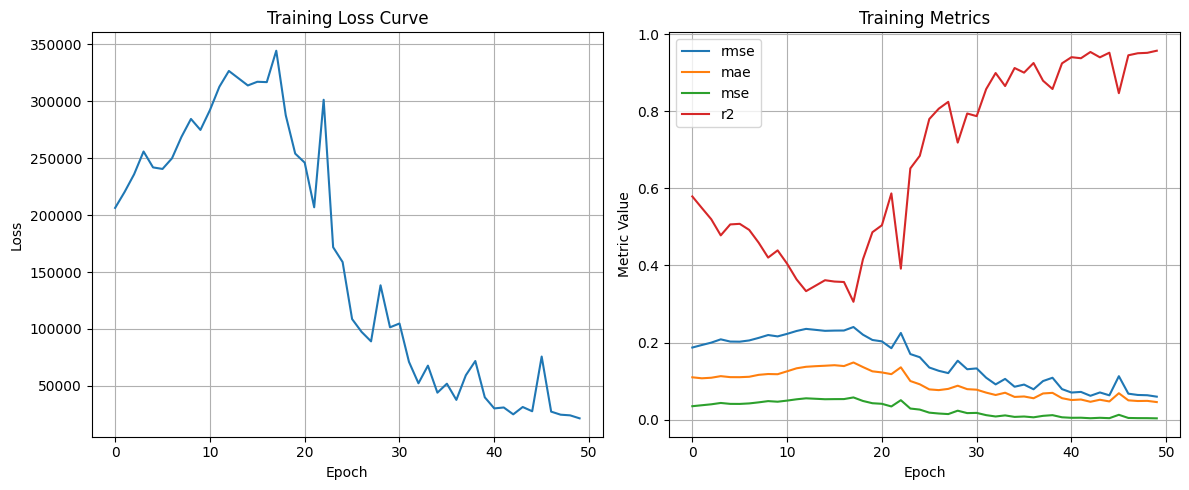

In [314]:
plot_training_history(
    train_results['train_loss'],
    {
        'rmse': train_results['train_rmse'],
        'mae': train_results['train_mae'],
        'mse': train_results['train_mse'],
        'r2': train_results['train_r2'],
    }
)

In [182]:
len(test_loader)

113

In [318]:
model.load_state_dict(torch.load('best_r2_model.pth', weights_only=True))

def test(
    model,
    test_loader,
    device,
):
    model.eval()

    test_preds = []
    test_targets = []

    test_r2 = []
    test_mae = []
    test_mse = []
    test_rmse = []
    
    with torch.no_grad():
        for data, labels in tqdm(test_loader):
            data = data.to(device)
            labels = labels.to(device)
            predictions = model(data).flatten()
            
            # predictions = torch.cummin(predictions.flip(0), dim=0).values.flip(-1)

            test_preds.append(predictions)
            test_targets.append(labels)

        test_preds = torch.cat(test_preds).cpu().detach().numpy()
        test_targets = torch.cat(test_targets).cpu().detach().numpy()

        mse = mean_squared_error(test_targets, test_preds)

        test_r2.append(r2_score(test_targets, test_preds))
        test_mae.append(mean_absolute_error(test_targets, test_preds))
        test_mse.append(mse)
        test_rmse.append(np.sqrt(mse))

    return {
        'test_r2': test_r2,
        'test_mae': test_mae,
        'test_mse': test_mse,
        'test_rmse': test_rmse,
        'test_preds': test_preds,
        'test_targets': test_targets,
    }
          

In [319]:
test_results = test(model, test_loader, device)

test_results

100%|██████████| 113/113 [00:00<00:00, 156.55it/s]


{'test_r2': [-2.300435542514811],
 'test_mae': [0.38305703],
 'test_mse': [0.15817097],
 'test_rmse': [0.39770713],
 'test_preds': array([0.4776669 , 0.48015353, 0.48236725, ..., 0.19974852, 0.20821479,
        0.1579358 ], dtype=float32),
 'test_targets': array([[0.99962103],
        [0.9994105 ],
        [0.9992    ],
        ...,
        [0.24190493],
        [0.24169439],
        [0.24148385]], dtype=float32)}

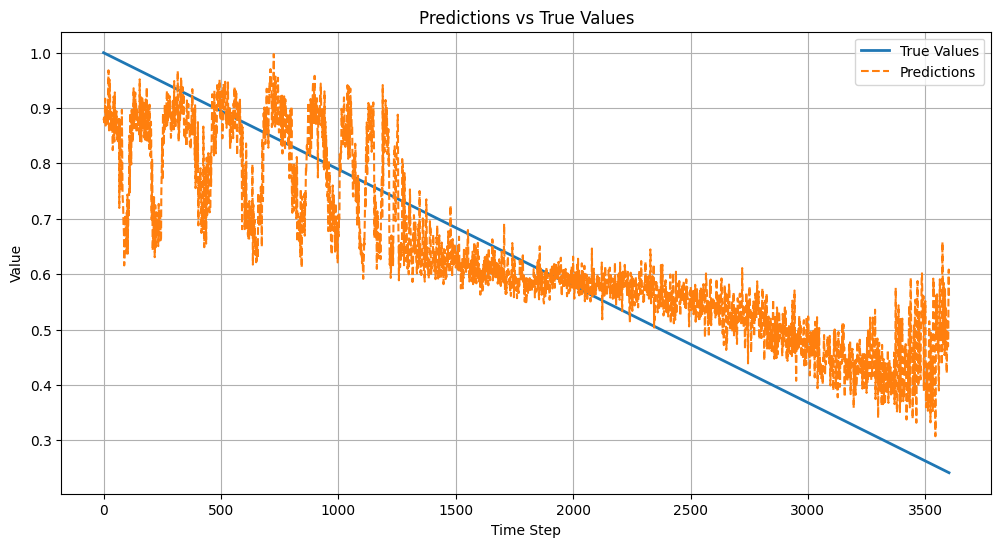

In [321]:
plot_predictions_vs_actuals(
    test_results['test_targets'],
    test_results['test_preds'] + 0.4
)

In [ ]:
test_results['test_targets']

(4602, 1)

In [300]:
test_results['test_preds']

array([0.02777791, 0.02777791, 0.02777791, ..., 0.02777791, 0.02777791,
       0.02777791], dtype=float32)

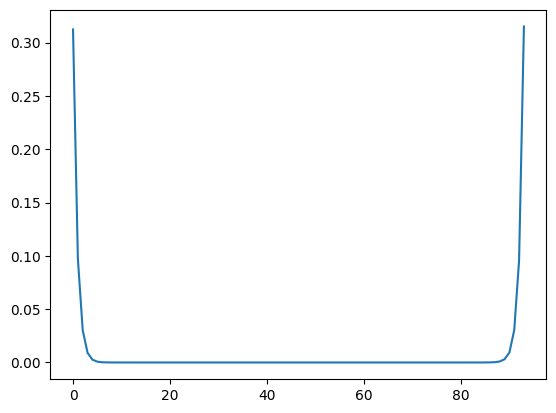

In [151]:
plt.plot(test_results['rul'].cpu().numpy())